In [2]:
import pandas as pd
import math
import numpy as np
from us import states

# Import SQL Alchemy
from sqlalchemy import create_engine

# Import and establish Base for which classes will be constructed 
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

# Import modules to declare columns and column data types
from sqlalchemy import Column, Integer, String, Float, Date, VARCHAR

from sqlalchemy.orm import sessionmaker
# from sqlalchemy import Table,Column,Integer,String
import glob
import os
from sqlalchemy import MetaData
from sqlalchemy.orm import mapper

In [19]:
myfile="PMMS_history.csv"
df=pd.read_csv(myfile)
df['month']=df['date'].str.split('/',n=3,expand=True)[0]
df['year']=df['date'].str.split('/',n=3,expand=True)[2]

mo_yr=['month','year']

df=df.sort_values('date')
last_df=df.sort_values('date').groupby(mo_yr).tail(1).drop(columns=['date']).rename(columns={'pmms30':'int_rate'})
last_df['time']=pd.to_datetime(last_df['year'].astype(str)+"-"+ last_df['month'].astype(str)+'-1', format='%Y-%m')
sort_vars=['year','month']
last_df['year'] = last_df['year'].astype(int)
last_df=last_df.loc[last_df['year']>2012]
last_df['year'] = last_df['year'].astype(str)
last_df=last_df.sort_values('time')
last_df.reset_index(inplace=True, drop=True)
last_df.reset_index(inplace=True)
last_df=last_df.rename(columns={'index':'ts'})

last_df.head()


,ts,int_rate,month,year,time
0,0,3.53,1,2013,2013-01-01
1,1,3.53,2,2013,2013-02-01
2,2,3.52,3,2013,2013-03-01
3,3,3.54,4,2013,2013-04-01
4,4,3.42,5,2013,2013-05-01


In [20]:
myfile="zillow.csv"
df=pd.read_csv(myfile, dtype={'StateCodeFIPS': 'str','MunicipalCodeFIPS':'str'})
loc_vars=['RegionName','State','StateCodeFIPS','MunicipalCodeFIPS']
df=df.melt(id_vars=loc_vars)
df['month']=df['variable'].str.split('_',n=3,expand=True)[0]
df['year']=df['variable'].str.split('_',n=3,expand=True)[2]
df['FIPS']=df['StateCodeFIPS']+df['MunicipalCodeFIPS']
property_df=df.drop(columns='variable')
property_df.head()

,RegionName,State,StateCodeFIPS,MunicipalCodeFIPS,value,month,year,FIPS
0,Los Angeles County,CA,06,037,174806.0,1,1996,06037
1,Cook County,IL,17,031,157181.0,1,1996,17031
2,Harris County,TX,48,201,100825.0,1,1996,48201
3,Maricopa County,AZ,04,013,115807.0,1,1996,04013
4,San Diego County,CA,06,073,177310.0,1,1996,06073


In [21]:
real_estate_df=pd.merge(property_df,last_df,how='inner',on=mo_yr).dropna().drop(columns=['StateCodeFIPS','MunicipalCodeFIPS'])
real_estate_df=real_estate_df.rename(columns={'State':'abbrev','FIPS':'fips','RegionName':'county'})
real_estate_df.head()

,county,abbrev,value,month,year,fips,ts,int_rate,time
0,Los Angeles County,CA,389142.0,1,2013,06037,0,3.53,2013-01-01
1,Cook County,IL,187933.0,1,2013,17031,0,3.53,2013-01-01
2,Harris County,TX,131555.0,1,2013,48201,0,3.53,2013-01-01
3,Maricopa County,AZ,176324.0,1,2013,04013,0,3.53,2013-01-01
4,San Diego County,CA,379667.0,1,2013,06073,0,3.53,2013-01-01


In [22]:
# Create the Property class
class Property(Base):
    __tablename__ = 'property'
    id = Column(Integer, primary_key=True, nullable=False) 
    county = Column(VARCHAR)
    abbrev = Column(VARCHAR)
    value = Column(Integer)
    month = Column(Integer)
    year = Column(Integer)
    fips = Column(VARCHAR)
    ts = Column(Integer)
    int_rate=Column(Float)
    time = Column(VARCHAR)


C:\Users\linda\anaconda3\lib\site-packages\sqlalchemy\ext\declarative\clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as __main__.Property, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)


InvalidRequestError: Table 'property' is already defined for this MetaData instance.  Specify 'extend_existing=True' to redefine options and columns on an existing Table object.

In [24]:
# Create a connection to a SQLite database
engine = create_engine('sqlite:///resources/ProjectThree.db')
# Create the garbage_collection table within the database
Base.metadata.create_all(engine)
real_estate_df.to_sql(con=engine, name= Property.__tablename__, index = False, if_exists='append')
prop_sqlite = pd.read_sql('SELECT * FROM Property', con=engine)
prop_sqlite

,id,county,abbrev,value,month,year,fips,ts,int_rate,time
0,1,Los Angeles County,CA,389142,1,2013,06037,0,3.53,2013-01-01 00:00:00.000000
1,2,Cook County,IL,187933,1,2013,17031,0,3.53,2013-01-01 00:00:00.000000
2,3,Harris County,TX,131555,1,2013,48201,0,3.53,2013-01-01 00:00:00.000000
3,4,Maricopa County,AZ,176324,1,2013,04013,0,3.53,2013-01-01 00:00:00.000000
4,5,San Diego County,CA,379667,1,2013,06073,0,3.53,2013-01-01 00:00:00.000000
...,...,...,...,...,...,...,...,...,...,...
257768,257769,Camas County,ID,157501,9,2020,16025,92,2.93,2020-09-01 00:00:00.000000
257769,257770,Daggett County,UT,201642,9,2020,49009,92,2.93,2020-09-01 00:00:00.000000
257770,257771,Hinsdale County,CO,369449,9,2020,08053,92,2.93,2020-09-01 00:00:00.000000
257771,257772,Mineral County,CO,278179,9,2020,08079,92,2.93,2020-09-01 00:00:00.000000


In [25]:
import matplotlib.pyplot as plt
import numpy as np

In [38]:
#skook 42107
#hunterdon 34019
state_df=real_estate_df.loc[(real_estate_df['fips']=='36047')]
#state_df=real_estate_df.loc[(real_estate_df['abbrev']=='NY')]
avg_df=state_df.groupby(by="ts", as_index=False).mean()
avg_df


,ts,value,year,int_rate
0,0,408411.0,2013,3.53
1,1,411042.0,2013,3.53
2,2,412737.0,2013,3.52
3,3,413296.0,2013,3.54
4,4,414600.0,2013,3.42
...,...,...,...,...
88,88,629200.0,2020,3.26
89,89,630627.0,2020,3.18
90,90,632494.0,2020,3.03
91,91,636094.0,2020,2.88


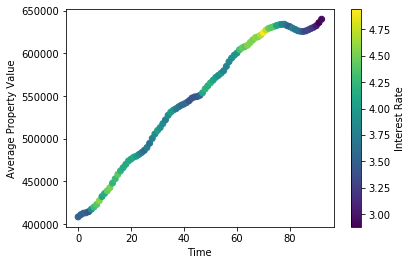

In [39]:
import matplotlib.pyplot as plt
plt.scatter(state_df['ts'],state_df['value'], c=state_df['int_rate'])
clb=plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Average Property Value')
clb.set_label("Interest Rate")
plt.show()

In [40]:
import matplotlib.pyplot as plt
import numpy as np
X = state_df[["int_rate","ts"]]
y = state_df["value"].values.reshape(-1, 1)
print(X.shape, y.shape)

(93, 2) (93, 1)


In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

model = LinearRegression()

X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=23)


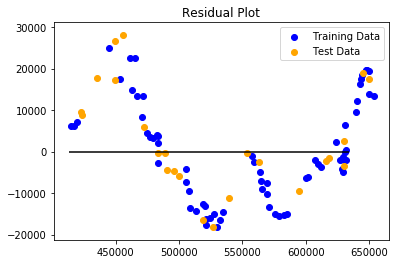

In [42]:
model.fit(X_train, y_train)
predictions=model.predict(X_test)
model.fit(X_train,y_train)
plt.scatter(model.predict(X_train),model.predict(X_train)-y_train, c="blue",label="Training Data")
plt.scatter(model.predict(X_test),model.predict(X_test)-y_test, c="orange",label="Test Data") 
plt.legend()
plt.hlines(y=0,xmin=y_test.min(),xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error

MSE=mean_squared_error(y_test,predictions)
r2=model.score(X_test,y_test)
coeff=model.coef_[0]
print(f"MSE:{MSE},R2:{r2}, interest rate coefficient: {coeff}, month coefficient: {coeff}")

MSE:162788233.38239607,R2:0.9730243056585327, interest rate coefficient: [18454.15356843  2717.54887901], month coefficient: [18454.15356843  2717.54887901]


In [45]:
start=max(state_df['ts'].to_list())
X_future=[[2.75,start+12],[3.00,start+12],[3.25,start+12],[3.50,start+12],[3.75,start+12],[4.00,start+12],[4.25,start+12], [4.50, start+12], [4.75,start+12],[5.00, start+12]]
y_future=model.predict(X_future)

length = len(X_future)
for i in range(length):
    print(f"Avg property value with interest rate={X_future[i]} is {y_future[i]}.")


Avg property value with interest rate=[2.75, 104] is [682795.94068799].
Avg property value with interest rate=[3.0, 104] is [687409.4790801].
Avg property value with interest rate=[3.25, 104] is [692023.0174722].
Avg property value with interest rate=[3.5, 104] is [696636.55586431].
Avg property value with interest rate=[3.75, 104] is [701250.09425642].
Avg property value with interest rate=[4.0, 104] is [705863.63264853].
Avg property value with interest rate=[4.25, 104] is [710477.17104063].
Avg property value with interest rate=[4.5, 104] is [715090.70943274].
Avg property value with interest rate=[4.75, 104] is [719704.24782485].
Avg property value with interest rate=[5.0, 104] is [724317.78621695].


In [ ]:
###LASSO
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=.01).fit(X_train,y_train)
predictions=lasso.predict(X_test)
MSE=mean_squared_error(y_test,predictions)
r2=lasso.score(X_test,y_test)
print(f"MSE:{MSE},R2:{r2}")

In [ ]:
#Ridge
from sklearn.linear_model import Ridge
ridge=Ridge(alpha=.01).fit(X_train,y_train)
predictions=ridge.predict(X_test)
MSE=mean_squared_error(y_test,predictions)
r2=ridge.score(X_test,y_test)
print(f"MSE:{MSE},R2:{r2}")

In [ ]:
##ElasticNet
from sklearn.linear_model import ElasticNet
enet=ElasticNet(alpha=.01).fit(X_train,y_train)
predictions=enet.predict(X_test)
MSE=mean_squared_error(y_test,predictions)
r2=enet.score(X_test,y_test)
print(f"MSE:{MSE},R2:{r2}")

In [ ]:
######scaled model########

X_scaler=StandardScaler().fit(X_train)
y_scaler=StandardScaler().fit(y_train)


In [ ]:
X_train_scaled=X_scaler.transform(X_train)
X_test_scaled=X_scaler.transform(X_test)
y_train_scaled=y_scaler.transform(y_train)
y_test_scaled=y_scaler.transform(y_test)


In [ ]:
model.fit(X_train_scaled, y_train_scaled)
model.score(X_test_scaled,y_test_scaled)


In [ ]:
predictions=model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled),model.predict(X_train_scaled)-y_train_scaled,c="blue",label="Training Data")
plt.scatter(model.predict(X_test_scaled),model.predict(X_test_scaled)-y_test_scaled,c="orange",label="Testing Data")
plt.legend()
plt.hlines(y=0,xmin=y_test_scaled.min(),xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

In [ ]:
MSE=mean_squared_error(y_test_scaled,predictions)
r2=model.score(X_test_scaled,y_test_scaled)
print(f"MSE:{MSE},R2:{r2}")